In [54]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

In [33]:
data = pd.read_csv('raw_data/ActR08TATB.csv', delimiter=';')
data.head(5)

,TA,TB
0,9.67,6.45
1,9.62,9.64
2,9.50,8.53
3,10.88,9.20
4,8.94,4.55


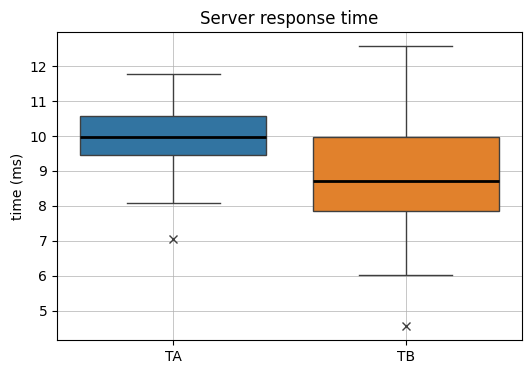

In [34]:
plt.figure(figsize=(6, 4))
ax = sns.boxplot(data=data,
                 flierprops={"marker": "x"},
                 medianprops={"color": "black", "linewidth": 2})
plt.grid(lw=0.5)
plt.title('Server response time')
plt.ylabel('time (ms)')
plt.show()


In [35]:
mean_ta = data.TA.mean()
mean_tb = data.TB.mean()
mean_ta - mean_tb

1.0322000000000013

In [47]:
mean_ta

9.935

In [48]:
mean_tb

8.9028

In [52]:
variance_ta = data.TA.var()
variance_ta

0.8103397959183676

In [53]:
variance_tb = data.TB.var()
variance_tb

3.052906285714285

In [55]:
z = (mean_ta - mean_tb) / (math.sqrt((variance_ta/len(data.TA) + variance_tb/len(data.TB))))
z

3.7134080154690747

In [57]:
from scipy.stats import norm
1-norm.cdf(z)

0.0001022434048687515

b

In [63]:
from scipy import stats
z = norm.ppf(.005)
z

-2.575829303548901

In [65]:
m = z*math.sqrt((variance_ta/len(data.TA))+(variance_tb/len(data.TB)))
m

-0.715992154928153

In [66]:
(mean_ta-mean_tb) + m

0.3162078450718483

In [67]:
(mean_ta-mean_tb) - m

1.7481921549281543

C

old

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TA      50 non-null     float64
 1   TB      50 non-null     float64
dtypes: float64(2)
memory usage: 928.0 bytes


In [37]:
data.describe()

,TA,TB
count,50.000000,50.000000
mean,9.935000,8.902800
std,0.900189,1.747257
min,7.050000,4.550000
25%,9.445000,7.857500
50%,9.970000,8.710000
75%,10.580000,9.970000
max,11.790000,12.570000


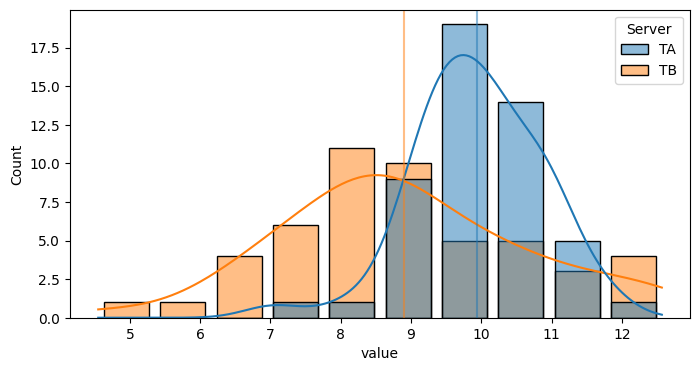

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(data=data.melt(), x='value', hue='variable', bins=10, kde=True,
             alpha=0.5, shrink=0.8, multiple='layer', ax=ax)

plt.axvline(data.TA.mean(), color='tab:blue', alpha=0.5)
plt.axvline(data.TB.mean(), color='tab:orange', alpha=0.5)

ax.legend_.set_title('Server')
plt.show()

In [39]:
from scipy import stats

res = stats.ttest_ind(a=data.TA,
                      b=data.TB,
                      equal_var=False,
                      alternative='two-sided')
print(f'p-value for single sided test: {res.pvalue}')

p-value for single sided test: 0.0003961202809152607


In [40]:
res

TtestResult(statistic=3.7134080154690747, pvalue=0.0003961202809152607, df=73.30030064949854)

In [41]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

def welch_ttest(x1, x2):

    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)

    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)

    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2

    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))

    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)

    # upper and lower bounds
    lb = delta - t.ppf(0.995,df)*pooled_se
    ub = delta + t.ppf(0.995,df)*pooled_se

    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

In [42]:
welch_ttest(data.TA,data.TB)

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,3.713408,73.300301,0.000396,1.0322,0.297098,1.767302


Proportion

In [43]:
tolerated_time = lambda x: 1 if x < 9 else 0

data['TA_tolerated'] = data['TA'].apply(tolerated_time)
data['TB_tolerated'] = data['TB'].apply(tolerated_time)

In [44]:
data.head(5)

,TA,TB,TA_tolerated,TB_tolerated
0,9.67,6.45,0,1
1,9.62,9.64,0,0
2,9.50,8.53,0,1
3,10.88,9.20,0,0
4,8.94,4.55,1,1


In [45]:
from scipy.stats import fisher_exact

# Assuming you have the counts for each category
TA_tolerated = data['TA_tolerated'].sum()  # Total count for TA tolerated
TB_tolerated = data['TB_tolerated'].sum()  # Total count for TB tolerated
TA_not_tolerated = len(data) - TA_tolerated  # Total count for TA not tolerated
TB_not_tolerated = len(data) - TB_tolerated  # Total count for TB not tolerated

# Creating the contingency table
contingency_table = [[TA_tolerated, TA_not_tolerated], [TB_tolerated, TB_not_tolerated]]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

print("Odds ratio:", odds_ratio)
print("p-value:", p_value)

Odds ratio: 0.08357771260997067
p-value: 3.063072832608735e-07
